In [ ]:
# -*- coding: utf-8 -*-
"""
Created: XXXX
Author: XXXXX
Department of Chemistry, Digital Chemistry Master course
Module: dml_submission.py
Local dependencies: network_classes.py, stats_and_plot_functions.py, rdkit_functions.py

Submission for the dML workshop Mar 2025 as part of the digital chemistry
masters. This applies delta learning to real world project data from the Troisi group.

See dml-brief for hints. I have done the data loading for you and given most of the 
packages you will need

"""

############## PACKAGE IMPORTS ###############
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt

############### LOCAL IMPORTS ###############
from network_classes import MLP 
from stats_and_plot_functions import mean_squared_error, calc_rhoc, plot_loss_and_r, CustomScaler


torch.manual_seed(42) # 42 for reproducibility
num=100 # Use this for testing and debugging
#num=None set to this when you want it to load
cwd = os.getcwd()
data_train = pd.read_csv(cwd+'/data/train_data_10k_conjugated_cores.csv')[:num]
data_test = pd.read_csv(cwd+'/data/test_data_500_analogues.csv') 

print("Formatting data - this may take a moment")
# Training data
train_Etddft = data_train['S1_TDDFT'].values 
train_Ezindo = data_train['S1_ZINDO'].values
train_fp = np.array([np.array(ast.literal_eval(fp), dtype=np.int32) for fp in data_train['fingerprint'].values])
net_input= np.concatenate((train_Ezindo.reshape(-1,1), train_fp),axis=1)

# Testing data (NOT VALIDATION DATA, use this once you model has been fully trained)
test_Etddft = data_test['E(S1_TDDFT)_analogue'].values 
test_Ezindo = data_test['E(S1_ZINDO)_analogue'].values
test_fp = np.array([np.array(ast.literal_eval(fp), dtype=np.int32) for fp in data_test['fingerprint'].values])


# Initialise model
criterion = nn.MSELoss()  

    





Formatting data - this may take a moment


In [3]:
# -*- coding: utf-8 -*-
"""
Created on Tue Feb 11 15:47:07 2025

Author: Adam Coxson, PhD student, University of Liverpool
Department of Chemistry, Materials Innovation Factory, Levershulme Research Centre
Module: network_classes.py
Local dependencies: None
For the dML workshop Mar 2025

# https://medium.com/@shashankshankar10/introduction-to-neural-networks-build-a-single-layer-perceptron-in-pytorch-c22d9b412ccf
# Numpy only perceptron: https://sebastianraschka.com/Articles/2015_singlelayer_neurons.html
# https://www.kaggle.com/code/pinocookie/pytorch-simple-mlp

Contains PyTorch classes for a 1-layer, 2-layer and variable multi-layer feedforward neural networks

"""

import torch.nn as nn
from torch.nn.modules import Module


################ NETWORK CLASSES ################

class SingleLayerPerceptron(nn.Module):
    """
    A simple single-layer perceptron model with one hidden layer.

    Parameters
    ----------
    input_dim : int
        Number of input features.
    hidden_dim : int, optional
        Number of neurons in the hidden layer (default is 100).
    output_dim : int, optional
        Number of output neurons (default is 1).
    activation_func : torch.nn.Module, optional
        Activation function applied after the hidden layer (default is None).

    Methods
    -------
    forward(x)
        Performs forward propagation through the network. Returns X, torch.Tensor object.
    """
    def __init__(self,
                 input_dim:  int,
                 hidden_dim: int = 100,
                 output_dim: int = 1,
                 activation_func=None
                 ): 
        super(SingleLayerPerceptron, self).__init__()
        
        # Define the layer variables and activation functions within class
        self.activation_func=activation_func
        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)

    def forward(self, x): # Propagate data through layers when class forward method is called
        x = x.view(x.size(0), -1)  # Flatten input if necessary
        x = self.hidden_layer(x)
        if self.activation_func is not None:
            x = self.activation_func(x)
        x = self.output_layer(x)
        return x  


class MLP_2layer(nn.Module):
    """
    A Multi-Layer Perceptron (MLP) with two hidden layers.
    
    Parameters
    ----------
    input_dim : int
        Number of input features.
    output_dim : int, optional
        Number of output neurons.
    neurons : list, optional
        List containing the number of neurons in each hidden layer (default is [200, 100]).
    activation_func : torch.nn.Module, optional
        Activation function applied after each hidden layer (default is ReLU).
    
    Methods
    -------
    forward(x)
        Performs forward propagation through the network. Returns X, torch.Tensor object.
    """
    
    def __init__(self,
                 input_dim:  int,
                 output_dim: int,
                 neurons:    list = [200,100],
                 activation_func  = None
                 ):
        super(MLP_2layer, self).__init__()
        if activation_func is None: activation_func=nn.ReLU()
        
        # Building the network object by hardcoding 2 layers
        self.layers = nn.Sequential( # Sequential pytorch container, forward method can be directly applied 
            nn.Linear(input_dim, neurons[0]),   # Add 1st hidden layer
            activation_func,                    # Apply activation to layer
            nn.Linear(neurons[0], neurons[1]),  # Add 2nd hidden layer
            activation_func,                    # Apply activation to layer
            nn.Linear(neurons[1], output_dim) # Linear output layer with no activation function
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layers(x)        # Apply data to Sequential object, that passes data through each layer for you
        return x

class MLP(nn.Module):
    """
    A flexible Multi-Layer Perceptron (MLP) that supports an arbitrary number of layers and activation functions.
    Note, the output neurons are linear and have no activation function (In some cases, like classification, sigmoid is used).
    Also applies dropout to the first 3 layers (Hardcoded in, feel free to change to make more flexible). Arguably, dropout
    is most impactful on the layers with most parameters. You can still apply it anywhere and eveywhere, but test it first.
    
    https://discuss.pytorch.org/t/how-to-create-mlp-model-with-arbitrary-number-of-hidden-layers/13124/5
    
    Parameters
    ----------
    input_dim : int
        Number of input features.
    output_dim : int
        Number of output neurons.
    layers_data : list
        List of tuples, each containing a layer size and an activation function (e.g., [(layer1, nn.ReLU()), (layer2, nn.ReLU()), ...]).
        Note, this does not account for the final layer, which is just a single final linear neuron.
    dropout : float, optional
        Dropout probability applied to the first three layers (default is 0).

    Methods
    -------
    forward(X)
        Performs forward propagation of data through the network. Returns X, torch.Tensor object.
    """

    def __init__(self,
                 input_dim:   int,
                 output_dim:  int,
                 layers_data: list,  #format [(layer1, nn.ReLU()), (layer2, nn.ReLU()), (output_size, nn.Sigmoid())]
                 dropout_prob:     float = 0
                 ):
        super().__init__()
        self.layers = nn.ModuleList() # Pytorch ModuleList does not have a forward method like nn.sequential
        self.dropout = nn.Dropout(p=dropout_prob)

        # Build the layers up sequentially (add nn.linear, add activation, add dropout, then loop to next layer)
        for i, (size, activation) in enumerate(layers_data): 
            self.layers.append(nn.Linear(input_dim, size))
            if i in [0,1,2]: # DROPOUT CURRENTLY BROKEN MAYBE?
                self.layers.append(self.dropout) # Apply dropout to output of first 3 hidden layers (currently hardcoded)
            input_dim = size  # Update input dimension for the next layer
            if activation is not None:
                assert isinstance(activation, Module), \
                    "Each tuple should contain a layer size (int) and a torch.nn.modules.Module."
                self.layers.append(activation)
        self.output = nn.Linear(input_dim, output_dim) # Final layer is a layer of linear neurons without an activation function

    def forward(self, X):
        for layer in self.layers: # Loop to propagate data over elements in ModuleList
            X = layer(X)
        #X = torch.sigmoid(self.output(X)) # Sometimes you could apply sigmoid or some other activation function on the output layer
        X = self.output(X)
        return X
    


Epoch [1/200], Training Loss: 0.46513, Valid Loss: 0.42462
Epoch [2/200], Training Loss: 0.29004, Valid Loss: 0.11127
Epoch [3/200], Training Loss: 0.04062, Valid Loss: 0.02348
Epoch [4/200], Training Loss: 0.02223, Valid Loss: 0.02187
Epoch [5/200], Training Loss: 0.02017, Valid Loss: 0.03052
Epoch [6/200], Training Loss: 0.01935, Valid Loss: 0.01896
Epoch [7/200], Training Loss: 0.01817, Valid Loss: 0.01555
Epoch [8/200], Training Loss: 0.01712, Valid Loss: 0.01763
Epoch [9/200], Training Loss: 0.01684, Valid Loss: 0.01568
Epoch [10/200], Training Loss: 0.01684, Valid Loss: 0.01849
Epoch [11/200], Training Loss: 0.01642, Valid Loss: 0.01927
Epoch [12/200], Training Loss: 0.01659, Valid Loss: 0.01560
Epoch [13/200], Training Loss: 0.01633, Valid Loss: 0.01814
Epoch [14/200], Training Loss: 0.01603, Valid Loss: 0.01421
Epoch [15/200], Training Loss: 0.01617, Valid Loss: 0.01508
Epoch [16/200], Training Loss: 0.01687, Valid Loss: 0.02400
Epoch [17/200], Training Loss: 0.01608, Valid Los

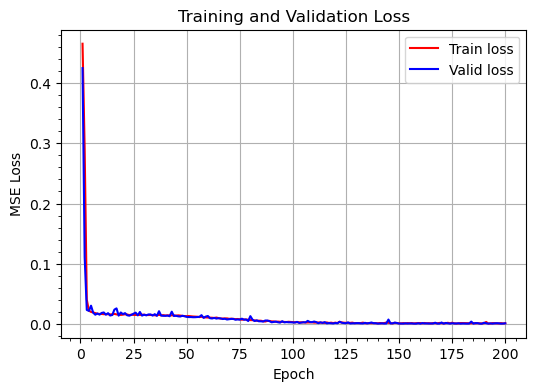

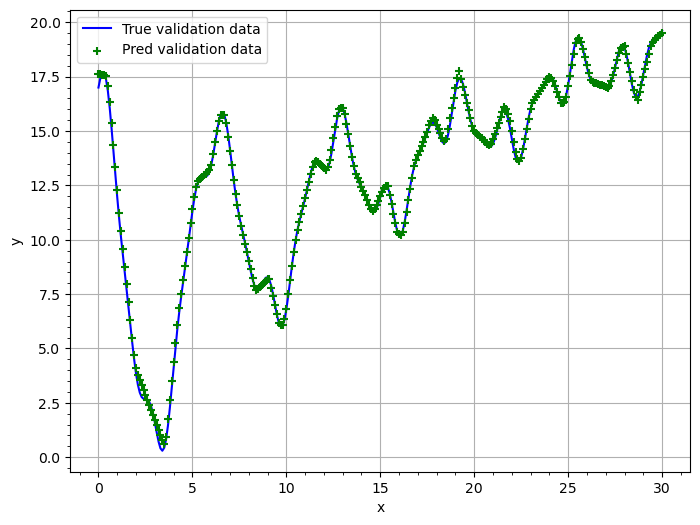

In [4]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jan 29 19:44:39 2025

Author: Adam Coxson, PhD student, University of Liverpool
Department of Chemistry, Materials Innovation Factory, Levershulme Research Centre
Module: network_models.py
Local dependencies: network_classes.py, stats_and_plot_functions.py
For the dML workshop Mar 2025

# https://medium.com/@shashankshankar10/introduction-to-neural-networks-build-a-single-layer-perceptron-in-pytorch-c22d9b412ccf
# Numpy only perceptron: https://sebastianraschka.com/Articles/2015_singlelayer_neurons.html
# https://www.kaggle.com/code/pinocookie/pytorch-simple-mlp

Trains a neural network on 1D regression data and visualises the results.
"""

############## PACKAGE IMPORTS ###############
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

############### LOCAL IMPORTS ###############
from network_classes import SingleLayerPerceptron, MLP_2layer, MLP 
from stats_and_plot_functions import compute_y, sample_x_values, normalize_data, mean_squared_error, plot_train_loss, doubleplot, calc_num_net_parameters


torch.manual_seed(42) # 42 for reproducibility

# Uncomment to show the True function of ((0.4*x + 0.5*np.sin(5*x) + np.sin(3*x)) + 10*np.cos(x)*np.exp(-0.1*x)) + 7
x_min, x_max, dx = 0, 30, 0.001
num_samples = 50
x_values = np.linspace(x_min, x_max, 300)
y_values = compute_y(x_values)
# Randomly sample x values and compute corresponding y values
sampled_x = sample_x_values(x_min, x_max, dx, num_samples)
sampled_y = compute_y(sampled_x)
# doubleplot(x_values, y_values, sampled_x, sampled_y,labels=["x","y","True function","50 Random 'training' points",""],lims=[[0,30],[0,20]])
# exit()

# Hyperparameters
input_dim = 1 # We only have one input dimension (the scalar x value)
output_dim = 1  # We only have one output dimension (the scalar y value)
learning_rate = 0.001
num_epochs = 200
batch_size = 32
neurons=[100,50,20,10]
#neurons=5000
#neurons=[100, 50]
# See list of different activation functions https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
activation = [nn.SELU(), nn.ReLU(), nn.Sigmoid()][1] 
dropout=0.0  # Careful with this as it may currently be broken



# Initialize model
#model = SingleLayerPerceptron(input_dim=1, hidden_dim=neurons, output_dim=1,activation_func=activation)
#model = MLP_2layer(input_dim=1,output_dim=1,neurons=neurons,activation_func=activation)
layers=[] # Format layers for variable MLP class
for n in neurons:
    layers.append((n, activation))
model = MLP(input_dim,output_dim,layers,dropout_prob=dropout)

if type(neurons) is list:
    nparams= calc_num_net_parameters(neurons.copy(), output_size=1)
else:
    nparams= calc_num_net_parameters(neurons, output_size=1)

# Training data params
training_samples=20000 
x_min, x_max=0,30

# Create and preprocess training data into 32 bit floats for PyTorch torch.Tensor objects
x_vals_train=sample_x_values(x_min, x_max, dx=0.00001, num_samples=training_samples).astype(np.float32)
y_vals_train = compute_y(x_vals_train).astype(np.float32)
x_vals_train_normalized, x_mean, x_std = normalize_data(x_vals_train)
y_vals_train_normalized, y_mean, y_std = normalize_data(y_vals_train)
X_train = torch.tensor(x_vals_train_normalized.reshape(len(x_vals_train),1), device='cpu')
y_train = torch.tensor(y_vals_train_normalized.reshape(len(y_vals_train),1), device='cpu')

# Create Validation data. In this simple case we are just sampling the true function, but realisitically it is taken from
# shuffled training data, i.e. for k-fold cross validation.
x_vals_valid=np.arange(x_min, x_max + 0.01, 0.1).astype(np.float32)
y_vals_valid = compute_y(x_vals_valid).astype(np.float32)
x_vals_valid_normalised = (x_vals_valid - x_mean) / x_std # DELIBERATELY Using normalisation from TRAINING data
y_vals_valid_normalised = (y_vals_valid - y_mean) / y_std # DELIBERATELY Using normalisation from TRAINING data
X_valid = torch.tensor(x_vals_valid_normalised.reshape(len(x_vals_valid),1), device='cpu')

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
criterion = nn.MSELoss()  
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

# Training loop with validation tracking
train_losses = []
valid_losses = []
best_valid_loss, best_train_loss, best_epoch = float("inf"), float("inf"), 0
best_model_state = None  # To store the best model state dict
for epoch in range(num_epochs):
    total_loss = 0.0
    model.train() # Tell model we are in training mode, weights can be modified, later we switch to evaluation mode
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        batch_X, batch_y = batch_X.float(), batch_y.float()
        outputs = model(batch_X).squeeze()  # Ensure output shape matches target
        loss = criterion(outputs, batch_y.squeeze())  # Compute loss
        loss.backward()  # Apply backpropagation
        optimizer.step()  # Update weights
        total_loss += loss.item()
    
    model.eval() # Important to tell the model we're in evaluation model, ensures no weights are changed by accident
    with torch.no_grad():
        valid_pred_normalized = np.squeeze(model(X_valid).detach().numpy()) # Predict validation data
    train_loss = total_loss / len(train_loader)
    valid_loss = mean_squared_error(y_vals_valid_normalised, valid_pred_normalized)  # Loss of true norm vs pred norm validation data
    train_losses.append(train_loss), valid_losses.append(valid_loss)

    # Save the best model based on validation loss
    if valid_loss < best_valid_loss:
        best_epoch = epoch
        best_valid_loss, best_train_loss = valid_loss, train_loss
        best_model_state = model.state_dict().copy()  # Save model state, not the whole model object

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.5f}, Valid Loss: {valid_loss:.5f}")
print("\nTraining complete.\n")
print("Number of training samples:",training_samples)
print("Neurons:",neurons,"("+str(nparams)+" parameters)","\nNum Epochs:", num_epochs,
      "\nLearning Rate:",learning_rate,"\nBatch Size:",batch_size,"\nActivation:",activation)
# Restore the best model before evaluation
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Best model from Epoch {best_epoch+1} restored with Training Loss: {best_train_loss:.5f} and Validation Loss: {best_valid_loss:.5f}")     
plot_train_loss(train_losses, valid_losses, labels=["Epoch", "MSE Loss", "Training and Validation Loss"])

# Final evaluation using the best model
model.eval() # Important to tell the model we're in evaluation model, ensures no weights are changed by accident
with torch.no_grad():
    valid_pred_normalized = np.squeeze(model(X_valid).detach().numpy())
y_vals_valid_predicted = (valid_pred_normalized * y_std) + y_mean # Unnormalise 

"""
####################### VISUALISE AND COMPARE THE TRUE AND PREDICTED DATA #######################

How good was the network at predicting the true function? Try different hyperparamters and samplings of the data.
"""
doubleplot(x_vals_valid, y_vals_valid, x_vals_valid, y_vals_valid_predicted, labels=["x","y","True validation data","Pred validation data",""])

    
    
    


In [5]:
# -*- coding: utf-8 -*-
"""
Created on Tue Feb 11 15:47:07 2025

Author: Adam Coxson, PhD student, University of Liverpool
Department of Chemistry, Materials Innovation Factory, Levershulme Research Centre
Module: stats_and_plot_functions.py
Local dependencies: None
For the dML workshop Mar 2025

Contains:
    1D and 2D equations for the workshop materials 
    Functions to sample input data for said functions
    Statistical measures for normalisation and error loss calcs
    Plotting functions to visualise data
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sklearn.preprocessing import StandardScaler

################## STATS AND SAMPLING FUNCTIONS ##################
def compute_y(x): # For 1D example
    return ((0.4*x + 0.5*np.sin(5*x) + np.sin(3*x)) + 10*np.cos(x)*np.exp(-0.1*x)) + 7

# For 1D example. 
def sample_x_values(x_min, x_max, dx, num_samples):
    """
    Randomly sample x values within a specified range and step size.
    
    Parameters
    ----------
    x_min : float
        Minimum x value.
    x_max : float
        Maximum x value.
    dx : float
        Step size for x values.
    num_samples : int
        Number of samples to draw.
    
    Returns
    -------
    np.array
        Randomly sampled x values.
    """
    possible_x = np.arange(x_min, x_max + dx, dx)  # generate contiguous possible x values
    return np.random.choice(possible_x, num_samples, replace=False)  # Randomly sample x vals

def compute_z(x, y): # For 2D example
    #z = 2 * np.exp(-0.2 * x) * (np.sin(x) ** 2) + (np.sin(2 * y) ** 3) + 1
    z = 0.8*np.exp(-0.2 * x) * (np.sin(x) ** 3) + 0.6*np.exp(-0.15 * y)*(np.sin(2 * y) ** 2) + 1.5
    return z
    

# Function to randomly sample x values within a range and a given step size
def sample_xy_values(x_min_max=[-5,5], y_min_max=[-5,5], dxdy=[0.001,0.001], num_samples=10000):
    possible_x = np.arange(x_min_max[0], x_min_max[1] + dxdy[0], dxdy[0])  # Generate possible x values
    possible_y = np.arange(y_min_max[0], y_min_max[1] + dxdy[1], dxdy[1])  # Generate possible x values
    choice_x= np.random.choice(possible_x, num_samples, replace=False)  # Randomly sample
    choice_y= np.random.choice(possible_y, num_samples, replace=False)  # Randomly sample
    return choice_x, choice_y

class CustomScaler:
    def __init__(self, num_scaled_cols=2):
        """
        Custom scaler that applies StandardScaler independently to the first `num_scaled_cols` columns
        while leaving the remaining columns unchanged.

        Parameters:
        num_scaled_cols (int): Number of columns to scale.
        """
        self.num_scaled_cols = num_scaled_cols
        self.scalers = [StandardScaler() for _ in range(num_scaled_cols)]

    def fit(self, X):
        """
        Fits the scalers independently to each of the first `num_scaled_cols` columns of X.

        Parameters:
        X (numpy array): The input data.
        """
        for i in range(self.num_scaled_cols):
            self.scalers[i].fit(X[:, i].reshape(-1, 1))
        return self

    def transform(self, X):
        """
        Transforms each of the first `num_scaled_cols` columns independently, keeping the rest unchanged.

        Parameters:
        X (numpy array): The input data.

        Returns:
        numpy array: The transformed data.
        """
        X_transformed = X.copy()
        for i in range(self.num_scaled_cols):
            X_transformed[:, i] = self.scalers[i].transform(X[:, i].reshape(-1, 1)).flatten()
        return X_transformed

    def fit_transform(self, X):
        """
        Fits the scalers and transforms the data.

        Parameters:
        X (numpy array): The input data.

        Returns:
        numpy array: The transformed data.
        """
        return self.fit(X).transform(X)

    def inverse_transform(self, X):
        """
        Inverses the transformation for the first `num_scaled_cols` columns.

        Parameters:
        X (numpy array): The transformed data.

        Returns:
        numpy array: The original scaled data.
        """
        X_original = X.copy()
        for i in range(self.num_scaled_cols):
            X_original[:, i] = self.scalers[i].inverse_transform(X[:, i].reshape(-1, 1)).flatten()
        return X_original

def normalize_data(vals): 
    """
    Very important to regularise data before training, don't forget to unnormalize any prediction data. 
    Can also use Sklearns StandardScaler. 
    Parameters
    ----------
    vals : np.array
        1D array of values to be normalise
    Returns
    -------
    norm_vals : np.array
        Normalised values.
    mean : float 
         Mean of the original values, returned for unscaling data later.
    std : float
        Standard deviation of the original values, returned for unscaling data later.

    """
    mean, std = vals.mean(), vals.std()
    norm_vals = ((vals - mean) / std).astype(np.float32)

    return norm_vals, mean, std

def mean_squared_error(y_true, y_pred): 
    return np.mean((y_true - y_pred) ** 2)

def calc_rhoc(x,y):
    ''' 
    Concordance Correlation Coefficient
    https://nirpyresearch.com/concordance-correlation-coefficient/
    '''
    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
    return rhoc

def calc_num_net_parameters(layer_config, output_size=1):
    if type(layer_config) is int:
        input_neurons = layer_config
        total_params = input_neurons * output_size + output_size
        return total_params
    
    elif type(layer_config[0]) is int and len(layer_config)==1:
        input_neurons = layer_config[0]
        output_neurons = output_size
        total_params = input_neurons * output_size + output_size
        return total_params
    
    if type(layer_config[0]) is not int:
        neurons=[]
        for n in layer_config:
            neurons.append(n[0])
        layer_config=neurons
    if layer_config[-1] != output_size:
        layer_config.append(1)
        
    total_params = 0
    for i in range(len(layer_config) - 1):
        input_neurons = layer_config[i]
        output_neurons = layer_config[i + 1]

        # Calculate weights and biases for the current layer
        weights = input_neurons * output_neurons
        biases = output_neurons

        # Add to the total parameters
        total_params += weights + biases

    return total_params

######### PLOTTING FUNCTIONS ###########

def plot_train_loss(train_loss, valid_loss=None, labels=["Epoch","MSE loss",""],figsize=(6,4)):
    """
    Plot training loss over epochs.
    
    Parameters
    ----------
    train_loss : list
        List of training loss values.
    valid_loss : list, optional
        List of validation loss values (default is None).
    labels : list, optional
        Labels for the plot axes and title (default is ["Epoch", "MSE loss", ""]).
    """
    plt.figure(figsize=figsize)
    x=np.arange(1,len(train_loss)+1) # Number of Epochs
    plt.plot(x, train_loss, 'r-',label='Train loss')
    if valid_loss is not None:
        plt.plot(x, valid_loss, 'b-',label='Valid loss')
        plt.legend()
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.title(labels[2])
    plt.grid(visible=True, which='major', axis='both')
    plt.minorticks_on()
    plt.show()
    return None

def plot_loss_and_r(train_loss, valid_loss, valid_r, figsize=(6,4)):
  
    x=np.arange(1,len(valid_loss)+1)
    fig, ax1 = plt.subplots(figsize=figsize)
    # Plotting the loss curves
    ax1.plot(x, train_loss, 'r-', label='Train Loss')
    ax1.plot(x, valid_loss, 'b-', label='Valid Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE loss', color='black')
    ax1.tick_params('y', colors='black')
    ax1.grid(visible=True, which='major', axis='both')
    ax1.minorticks_on()

    # Creating a secondary y-axis for correlation
    ax2 = ax1.twinx()
    ax2.plot(x, valid_r, 'g-', label='Correlation')
    ax2.set_ylabel('Correlation', color='black')
    ax2.tick_params('y', colors='black')
    ax2.minorticks_on()
            
    best_epoch=np.argmin(valid_loss)
    ax1.axvline(x=best_epoch+1, color='k', linestyle='-', alpha=0.8)

    # Adding legend
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    ax1.legend(lines, labels, loc='center right')

    # plt.title(title)
    # if save==True:
    #     plt.savefig(fname=savedir+title+'loss_plot.png')
    # if show == True:
    #     plt.show()
    return fig
    
def doubleplot(x1,y1,x2,y2,labels=["x","y","A","B",""],figsize=(8,6),lims=None):
    """
    Create a plot by overplotting two sets of data.
    
    Parameters
    ----------
    x1, y1 : array-like
        Data for the first plot (line).
    x2, y2 : array-like
        Data for the second plot (scatter).
    labels : list
        Labels for axes, datasets, and title.
    figsize : tuple
        Figure size.
    lims : tuple, optional
        Axis limits in the format ((x_min, x_max), (y_min, y_max)).
    """
    plt.figure(figsize=figsize)
    plt.plot(x1, y1, label=labels[2], color="blue")
    plt.scatter(x2, y2, color="green", marker="+", label=labels[3], zorder=3)
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.title(labels[4])
    plt.grid(True)
    plt.minorticks_on()
    if lims is not None:
        plt.xlim(lims[0][0],lims[0][1])
        plt.ylim(lims[1][0],lims[1][1])
    plt.legend()
    plt.show()
    return None

def heatmapplot(x,y,z,labels=["x","y","z",""],figsize=(8,6),alpha=0.75):
    plt.figure(figsize=figsize)
    plt.scatter(x, y, c=z, cmap='viridis', alpha=0.75)
    plt.colorbar(label=labels[2])
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.title(labels[3])
    plt.grid(True)
    plt.minorticks_on()
    plt.show()
    return None

def surfaceplot(x, y, z, labels=["x", "y", "z", "Surface Plot"], figsize=(8, 6)):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    xi = np.linspace(min(x), max(x), 200)
    yi = np.linspace(min(y), max(y), 200)
    Xi, Yi = np.meshgrid(xi, yi)
    Zi = griddata((x, y), z, (Xi, Yi), method='cubic')

    surf = ax.plot_surface(Xi, Yi, Zi, cmap='viridis', edgecolor='none')
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.set_title(labels[3])
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    plt.show()
    return None

def heatmapplot_subplots(x, y, z1, z2, z3, labels1, labels2, labels3, figsize=(18, 6), alpha=0.75):
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # First heatmap (Prediction)
    im1 = axes[0].scatter(x, y, c=z1, cmap='viridis', alpha=alpha)
    fig.colorbar(im1, ax=axes[0], label=labels1[2])
    axes[0].set_xlabel(labels1[0])
    axes[0].set_ylabel(labels1[1])
    axes[0].set_title(labels1[3])
    axes[0].grid(True)
    
    # Second heatmap (True values)
    im2 = axes[1].scatter(x, y, c=z2, cmap='viridis', alpha=alpha)
    fig.colorbar(im2, ax=axes[1], label=labels2[2])
    axes[1].set_xlabel(labels2[0])
    axes[1].set_ylabel(labels2[1])
    axes[1].set_title(labels2[3])
    axes[1].grid(True)
    
    # Third heatmap (Deviation)
    im3 = axes[2].scatter(x, y, c=z3, cmap='viridis', alpha=alpha)
    fig.colorbar(im3, ax=axes[2], label=labels3[2])
    axes[2].set_xlabel(labels3[0])
    axes[2].set_ylabel(labels3[1])
    axes[2].set_title(labels3[3])
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
def surfaceplot_subplots(x, y, z1, z2, z3, labels1, labels2, labels3, figsize=(18, 6)):
    fig = plt.figure(figsize=figsize)
    
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_trisurf(x, y, z1, cmap='viridis')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10, label=labels1[2])
    ax1.set_xlabel(labels1[0])
    ax1.set_ylabel(labels1[1])
    ax1.set_zlabel(labels1[2])
    ax1.set_title(labels1[3])
    
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_trisurf(x, y, z2, cmap='viridis')
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10, label=labels2[2])
    ax2.set_xlabel(labels2[0])
    ax2.set_ylabel(labels2[1])
    ax2.set_zlabel(labels2[2])
    ax2.set_title(labels2[3])
    
    ax3 = fig.add_subplot(133, projection='3d')
    surf3 = ax3.plot_trisurf(x, y, z3, cmap='viridis')
    fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=10, label=labels3[2])
    ax3.set_xlabel(labels3[0])
    ax3.set_ylabel(labels3[1])
    ax3.set_zlabel(labels3[2])
    ax3.set_title(labels3[3])
    
    plt.show()

# def surfaceplot_subplots(x, y, z1, z2, z3, labels1, labels2, labels3, figsize=(18, 6)):
#     fig = plt.figure(figsize=figsize)
    
#     ax1 = fig.add_subplot(131, projection='3d')
#     ax1.plot_trisurf(x, y, z1, cmap='viridis')
#     ax1.set_xlabel(labels1[0])
#     ax1.set_ylabel(labels1[1])
#     ax1.set_zlabel(labels1[2])
#     ax1.set_title(labels1[3])
    
#     ax2 = fig.add_subplot(132, projection='3d')
#     ax2.plot_trisurf(x, y, z2, cmap='viridis')
#     ax2.set_xlabel(labels2[0])
#     ax2.set_ylabel(labels2[1])
#     ax2.set_zlabel(labels2[2])
#     ax2.set_title(labels2[3])
    
#     ax3 = fig.add_subplot(133, projection='3d')
#     ax3.plot_trisurf(x, y, z3, cmap='viridis')
#     ax3.set_xlabel(labels3[0])
#     ax3.set_ylabel(labels3[1])
#     ax3.set_zlabel(labels3[2])
#     ax3.set_title(labels3[3])
    
#     plt.show()